In [1]:
import os

import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely

from scipy.stats import linregress
from reaches import *
from utils import *

In [2]:
# FOR NOW, SET
width_set = 'min'

# Control flow
if width_set == 'mean':
    width = 'WidthM'
    binn = 'Bin'
elif width_set == 'min':
    width = 'WidthM_Min'
    binn = 'Bin_Min'
elif width_set == 'max':
    width = 'WidthM_Max'
    binn = 'Bin_Max'
else:
    print('Invalid width option specified, exiting.')
    # sys.exit()

In [3]:
huc2 = '01' ### SET THIS
data_path = '/nas/cee-water/cjgleason/fiona/data/PIXC_v2_0_HUC2_' + huc2
# save_dir =

### Pixel Cloud

In [4]:
# Get job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
index = 106

In [5]:
huc2 = '01'
file_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/PIXC_v2_0_HUC2_' + huc2 + '_filtered.json'
data = open_json(file_path)

In [6]:
file_name = data[index]

In [7]:
# Get data for this tile
granule_name = file_name[:-3]
tile_name = file_name[20:28]
pass_num = int(file_name[20:23])

print(granule_name)

SWOT_L2_HR_PIXC_002_007_235R_20230811T080638_20230811T080649_PGC0_01


#### Read in PIXC

In [8]:
# Set PIXC filepath
pixc_path = os.path.join(data_path, file_name)

In [9]:
# Read in pixel group
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [10]:
# Make mask
mask = bitwiseMask(ds_PIXC)

if mask.shape[0] == 0:
    print('This granule has no pixels after masking, exiting.')
    # sys.exit(1)    

(761047,)


In [11]:
# Set desired data vars
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'height', 'geoid', 'prior_water_prob',
             'classification']

In [12]:
# Convert PIXC to GeoDataFrame
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)

### Find correct HUC4s

In [13]:
### NHDPlus HR
## Find correct HUC4s
# Read in tile and HUC4 intersection data
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
dtype_dic= {'tile': str, 'huc4': str, 'coverage': float}
tile_huc4 = pd.read_csv(os.path.join(mdata_path,
                                    'huc4_swot_science_tiles.csv'),
                        dtype=dtype_dic)

In [14]:
# Make list of HUC4s that intersect the tile
hucs = list(tile_huc4[(tile_huc4['tile'] == tile_name)]['huc4'])
# Limit to the current HUC2
hucs = [x for x in hucs if x.startswith(huc2)]

In [15]:
hucs

['0101', '0102', '0105']

In [16]:
# Get NHD index metadata
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
huc_lookup = pd.read_csv(os.path.join(mdata_path,
                                  'HUC4_lookup_no_great_lakes.csv'),
                     dtype=dtype_dic)

In [17]:
# Extract indices for read-in
indices = list(huc_lookup[huc_lookup['HUC4'].isin(hucs)]['slurm_index'])

### Read in HUC4 flowliness

In [18]:
# Create merged dataframe of all flowlines intersected
if len(indices) == 1:
    # Read prepped NHD
    flowlines, _, _,  = readNHD(index=indices[0])
    # huc4_list, huc2_list = readNHD(index=indices[0])
else:
    # Initialize lists
    d = []
    # huc4_list = []
    # huc2_list = []
    # Loop through indices and store in lists
    for i in indices:
        # Read prepped NHD
        flowlines, _, _ = readNHD(index=i)
        # huc4, huc2 = readNHD(index=i)
        # Append to lists
        d.append(flowlines)
        # huc4_list.append(huc4) # I DON'T DO ANYTHING WITH THIS
        # huc2_list.append(huc2) # I DON'T DO ANYTHING WITH THIS
    # Merge GeoDataFrames
    flowlines = pd.concat(d)

type: normal
NHDPLUS_H_0101_HU4_GDB
flowlines read-in
exploded
type: normal
NHDPLUS_H_0102_HU4_GDB
flowlines read-in
exploded
type: normal
NHDPLUS_H_0105_HU4_GDB
flowlines read-in
exploded


In [19]:
# Project CRS (currently to WGS 84 / UTM zone 18N) 
flowlines = flowlines.to_crs(epsg=3857)

### Nadir track

In [20]:
# Get single pixel for selecting correct nadir segment
pixel_pt = gdf_PIXC.iloc[0].geometry

In [21]:
# Find correct nadir segment and return its geometry
nadir_segment_ln = findNadir(pass_num=pass_num, pixel_pt=pixel_pt)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


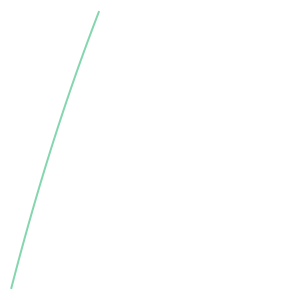

In [22]:
nadir_segment_ln

In [47]:
def calcAzSin(df):
    # Set-up
    line = df.geometry
    x_coords = [coord[0] for coord in line.coords]
    y_coords = [coord[1] for coord in line.coords]
    
    # Regress
    result = linregress(x_coords, y_coords)
    slope = result.slope
    intercept = result.intercept
    
    # Find deltas
    dx = x_coords[-1] - x_coords[0]
    dy = y_coords[-1] - y_coords[0]
    dy_reg = (slope*x_coords[-1] + intercept) - y_coords[0]
    
    # Find azimuth
    azimuth = math.degrees(math.atan2(dy_reg, dx))
        
    if azimuth < 0:
        azimuth += 360
    
    # Find sinuosity
    distance = np.sqrt(dx**2 + dy**2)
    
    sinuosity = line.length/distance
    
    return azimuth, sinuosity

In [49]:
df = flowlines.iloc[6]

In [50]:
az, sin = calcAzSin(df)

In [51]:
az

315.74662251281615

In [52]:
sin

np.float64(1.0153297442996871)

In [42]:
az_n, _ = calc_az_sin(line=nadir_segment_ln, nadir=True)

In [43]:
az_n

72.41249500094567

In [44]:
diff = np.abs(az - az_n)

In [45]:
diff

np.float64(243.33412751187046)

In [38]:
aligned = 0

if (diff < 45) or (diff >= 315):
    aligned = 1
elif (diff >= 135) and (diff < 225):
    aligned = 1

In [39]:
aligned

0